In [9]:
import numpy as np
import pandas as pd
import os
import sys
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
import optuna
import random
import joblib
import math
import ast
import logging
from msig import Motif, NullModel
from config import RESULTS_MOTIF_DIR, RESULTS_DIR, IMAGES_DIR, DATA_DIR, DATASET_PATH, TOWNSHIP_NAME, VARIABLES, NORMALIZE_FLAGS, STUMPY_EXCL_ZONE_DENOM, TOP_K_MP, INCLUDE, NORMALIZE, SUBSQUENCES_LENGTHS

print(f"Results will be saved in: {RESULTS_DIR}")
print(f"Images will be saved in: {IMAGES_DIR}")
print(f"Data will be accessed from: {DATA_DIR}")


if '__file__' in globals():
    # For standalone scripts
    base_dir = os.path.dirname(__file__)
else:
    # For Jupyter or interactive environments
    base_dir = os.getcwd()

# Add the parent directory of `utils` to the Python path
sys.path.append(os.path.abspath(os.path.join(base_dir, "../")))

Results will be saved in: /home/mgsilva/motifpred/results/populationdensity
Images will be saved in: /home/mgsilva/motifpred/images/populationdensity
Data will be accessed from: /home/mgsilva/motifpred/data/populationdensity


In [10]:

mp_stats_table = pd.read_csv(
    RESULTS_DIR / f"mp_stats_table_normalized_{NORMALIZE}_top_{TOP_K_MP}.csv"
)
mp_stats_table = mp_stats_table[["Features","m", "Indices"]]
motifs_sizes = mp_stats_table[["m"]].values.flatten().astype(int)
motifs_indexes = mp_stats_table[["Indices"]].values
motifs_indexes = [ast.literal_eval(item[0]) for item in motifs_indexes]


In [11]:
# read csv
data_df = pd.read_csv(
    DATASET_PATH,
    parse_dates=["one_time"],
    date_format="%Y-%m-%d %H:%M:%S",
    index_col=0,
)

data_df = data_df[data_df["township_name"] == TOWNSHIP_NAME]
#set index to one_time and township_name
data_df = data_df.set_index(["one_time", "township_name"]).sort_index()[VARIABLES]
data = data_df.to_numpy().T
data_df

,,sum_terminals,sum_roaming_terminals,sum_phonecalls
one_time,township_name,,,
2021-09-15 00:00:00,Avenidas Novas,260700.0,17678.0,2262.0
2021-09-15 01:00:00,Avenidas Novas,276675.0,17533.0,994.0
2021-09-15 02:00:00,Avenidas Novas,284563.0,15280.0,725.0
2021-09-15 03:00:00,Avenidas Novas,279563.0,12424.0,393.0
2021-09-15 04:00:00,Avenidas Novas,281460.0,10789.0,290.0
...,...,...,...,...
2021-11-30 19:00:00,Avenidas Novas,391367.0,12886.0,17569.0
2021-11-30 20:00:00,Avenidas Novas,352361.0,11026.0,13738.0
2021-11-30 21:00:00,Avenidas Novas,388246.0,13957.0,16368.0


In [12]:
# Import shared setup
from utils.setup import seed, device, early_stopper, pipeline, test_tensor

# Example usage
print(f"Device: {device}")
test_tensor()

Device: cuda
tensor([[0.8303, 0.1205, 0.7796],
        [0.8247, 0.3089, 0.9678],
        [0.1906, 0.7512, 0.0192],
        [0.7619, 0.9295, 0.9215],
        [0.8892, 0.5067, 0.5140]])


TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244

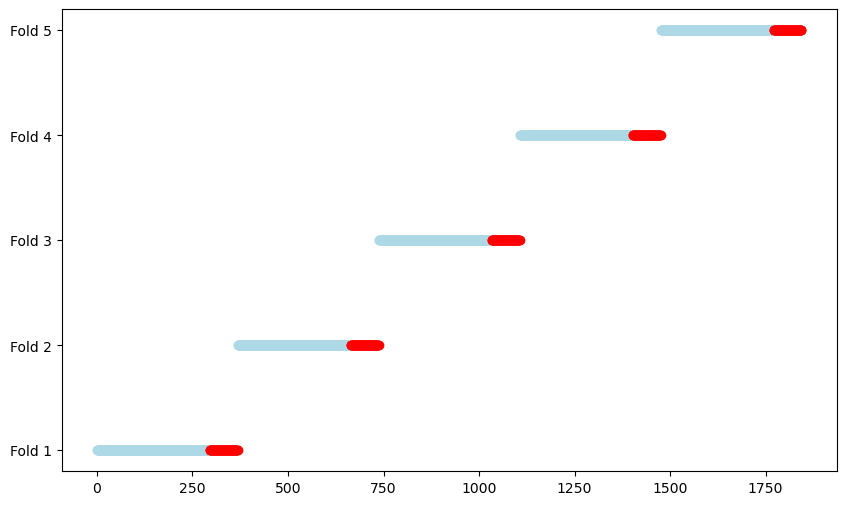

In [13]:
from utils.timeseries_split import BlockingTimeSeriesSplit

#create index  
indexes = np.arange(len(data[0]))

#split data
tscv = BlockingTimeSeriesSplit(n_splits=5)
# Create the figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(indexes)):
    # Plot train and test indices
    ax.plot(train_index, np.zeros_like(train_index) + i, 'o', color='lightblue')
    ax.plot(test_index, np.zeros_like(test_index) + i, 'o', color='red')
    print("TRAIN:", train_index, "TEST:", test_index)
    

ax.set_yticks(np.arange(5), ["Fold {}".format(i) for i in range(1, 6)])
plt.show()

In [14]:
from utils.utils import create_multi_motif_dataset

lookback_period = 100 #window size
step = 5 #step size for the sliding window
forecast_period = 50 #forward window size

#X_series: past window, X_indices: indexes of the motif in the window,  y: next relative index of the motif
X_series, X_indices, X_mask, y = create_multi_motif_dataset(data, lookback_period, step, forecast_period, motifs_indexes, motifs_sizes)

# X_series, X2, and y are now PyTorch tensors
print("X_series shape:", X_series.shape)  # Expected shape: (num_samples, lookback_period, num_features)
print("X_mask shape:", X_mask.shape)  # Expected shape: (num_samples, lookback_period)
print("X_indices shape:", X_indices.shape)  # Expected shape: (num_samples, max_motif_length_in_window, 1)
print("y shape:", y.shape)    # Expected shape: (num_samples, 1)


X_series shape: torch.Size([15676, 100, 3])
X_mask shape: torch.Size([15676, 100])
X_indices shape: torch.Size([15676, 8, 1])
y shape: torch.Size([15676, 1])


[I 2025-01-21 15:42:28,163] A new study created in memory with name: no-name-a327c6f8-dd2e-416b-bc9a-16dd2ddcb926


Training completed all epochs. Best epoch was 67
Training completed all epochs. Best epoch was 11
Training completed all epochs. Best epoch was 21
Training completed all epochs. Best epoch was 13


[I 2025-01-21 15:50:44,334] Trial 0 finished with value: 169.28392028808594 and parameters: {'learning_rate': 2.6565450821928437e-05, 'd_model': 256, 'n_heads': 16, 'e_layers': 3, 'dim_feedforward': 128, 'dropout': 0.25599658869775177, 'batch_size': 16}. Best is trial 0 with value: 169.28392028808594.


Training completed all epochs. Best epoch was 69
Training completed all epochs. Best epoch was 98
Training completed all epochs. Best epoch was 52
Training completed all epochs. Best epoch was 83
Training completed all epochs. Best epoch was 59


[I 2025-01-21 15:53:51,078] Trial 1 finished with value: 171.1730529785156 and parameters: {'learning_rate': 4.946096107589924e-05, 'd_model': 64, 'n_heads': 16, 'e_layers': 2, 'dim_feedforward': 512, 'dropout': 0.42903854381849826, 'batch_size': 32}. Best is trial 0 with value: 169.28392028808594.


Training completed all epochs. Best epoch was 98
Best hyperparameters: {'learning_rate': 2.6565450821928437e-05, 'd_model': 256, 'n_heads': 16, 'e_layers': 3, 'dim_feedforward': 128, 'dropout': 0.25599658869775177, 'batch_size': 16}
Number of finished trials:  2
Best trial: 0
Best hyperparameters: {'learning_rate': 2.6565450821928437e-05, 'd_model': 256, 'n_heads': 16, 'e_layers': 3, 'dim_feedforward': 128, 'dropout': 0.25599658869775177, 'batch_size': 16}
Validation Losses: [182.61, 140.553, 178.535, 167.979, 176.742]
Mean validation loss: 169.284
Test Losses: [179.223, 189.182, 226.063, 201.632, 187.549]
Mean test loss: 196.73
Mean test MAE: 11.892 std: 0.558
Mean test RMSE: 14.014 std: 0.573


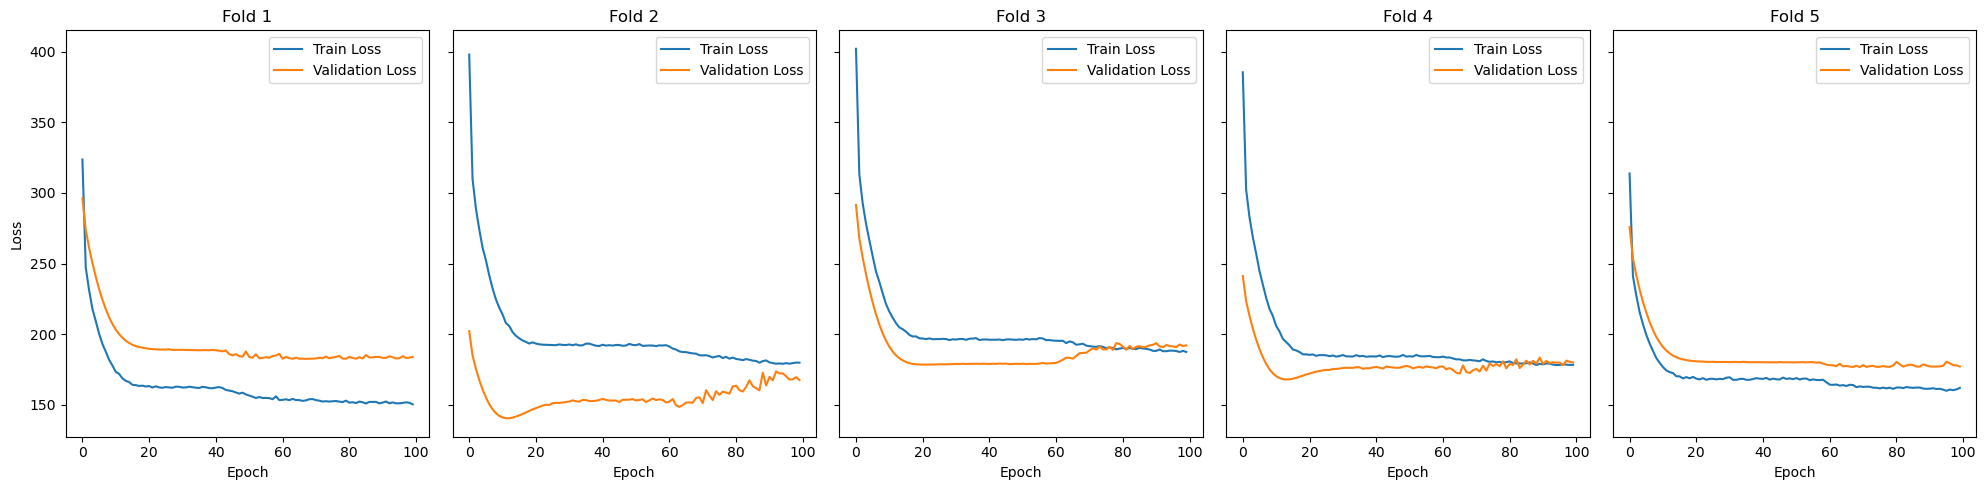

In [15]:
from models.transformer_pytorch import TimeSeriesTransformer
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results

n_trials = 2
num_epochs = 100
model_type = "Transformer"
model_name = "TransformerSeries"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "d_model": {
        "type": "categorical",
        "args": [[64, 128, 256, 512]]
    },
    "n_heads": {
        "type": "categorical",
        "args": [[2, 4, 8, 16]]
    },
    "e_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]
    },
    "dim_feedforward": {
        "type": "categorical",
        "args": [[128, 256, 512]]
    },
    "dropout": {
        "type": "float",
        "args": [0.0, 0.5]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}

model_params_keys = ["d_model", "n_heads", "e_layers", "dim_feedforward", "dropout"]


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

X = {"X_series": X_series}
run_optuna_study(pipeline.run_cross_val, TimeSeriesTransformer, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(
    study.trials_dataframe(),
    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png")
)

[I 2025-01-21 15:53:51,416] A new study created in memory with name: no-name-c028249e-af1f-4f90-81de-a7f6384f99f4


Training completed all epochs. Best epoch was 50
Training completed all epochs. Best epoch was 11
Training completed all epochs. Best epoch was 22
Training completed all epochs. Best epoch was 13


[I 2025-01-21 16:02:21,504] Trial 0 finished with value: 169.754638671875 and parameters: {'learning_rate': 2.6565450821928437e-05, 'd_model': 256, 'n_heads': 16, 'e_layers': 3, 'dim_feedforward': 128, 'dropout': 0.25599658869775177, 'batch_size': 16}. Best is trial 0 with value: 169.754638671875.


Training completed all epochs. Best epoch was 97
Training completed all epochs. Best epoch was 99
Training completed all epochs. Best epoch was 51
Training completed all epochs. Best epoch was 79
Training completed all epochs. Best epoch was 55


[I 2025-01-21 16:04:50,743] Trial 1 finished with value: 171.2141326904297 and parameters: {'learning_rate': 4.946096107589924e-05, 'd_model': 64, 'n_heads': 16, 'e_layers': 2, 'dim_feedforward': 512, 'dropout': 0.42903854381849826, 'batch_size': 32}. Best is trial 0 with value: 169.754638671875.


Training completed all epochs. Best epoch was 98
Training completed all epochs. Best epoch was 96
Training completed all epochs. Best epoch was 37
Training completed all epochs. Best epoch was 99
Training completed all epochs. Best epoch was 49


[I 2025-01-21 16:09:20,306] Trial 2 finished with value: 171.0760955810547 and parameters: {'learning_rate': 1.924766724430935e-05, 'd_model': 512, 'n_heads': 4, 'e_layers': 3, 'dim_feedforward': 128, 'dropout': 0.023822839129258366, 'batch_size': 128}. Best is trial 0 with value: 169.754638671875.


Training completed all epochs. Best epoch was 97
Best hyperparameters: {'learning_rate': 2.6565450821928437e-05, 'd_model': 256, 'n_heads': 16, 'e_layers': 3, 'dim_feedforward': 128, 'dropout': 0.25599658869775177, 'batch_size': 16}
Number of finished trials:  3
Best trial: 0
Best hyperparameters: {'learning_rate': 2.6565450821928437e-05, 'd_model': 256, 'n_heads': 16, 'e_layers': 3, 'dim_feedforward': 128, 'dropout': 0.25599658869775177, 'batch_size': 16}
Validation Losses: [185.404, 140.49, 178.529, 167.983, 176.367]
Mean validation loss: 169.755
Test Losses: [174.098, 188.519, 220.043, 202.928, 189.03]
Mean test loss: 194.924
Mean test MAE: 11.861 std: 0.682
Mean test RMSE: 13.951 std: 0.553


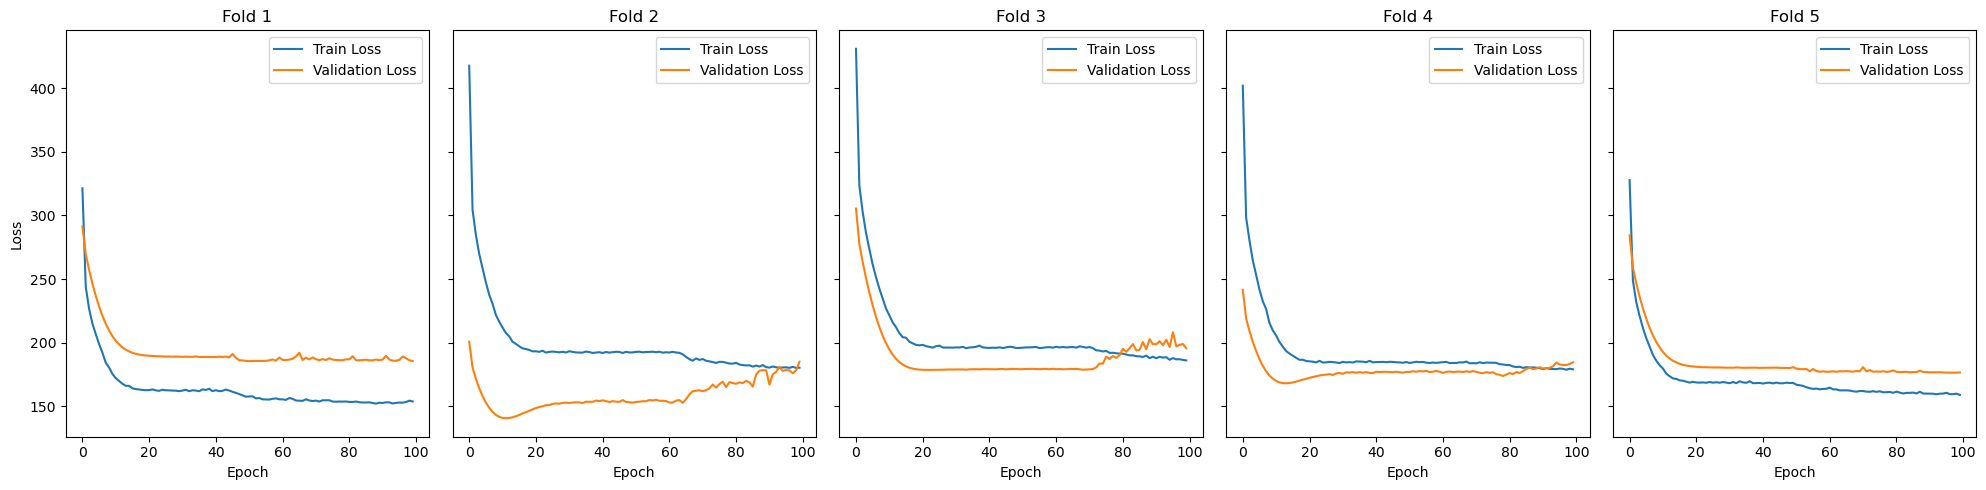

In [16]:
from models.transformer_pytorch import TimeSeriesTransformer
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results

n_trials = 3
num_epochs = 100
model_type = "Transformer"
model_name = "TransformerSeries_X2Masking"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "d_model": {
        "type": "categorical",
        "args": [[64, 128, 256, 512]]
    },
    "n_heads": {
        "type": "categorical",
        "args": [[2, 4, 8, 16]]
    },
    "e_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]
    },
    "dim_feedforward": {
        "type": "categorical",
        "args": [[128, 256, 512]]
    },
    "dropout": {
        "type": "float",
        "args": [0.0, 0.5]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}

model_params_keys = ["d_model", "n_heads", "e_layers", "dim_feedforward", "dropout"]


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

X = {"X_series": X_series, "X_mask": X_mask}
run_optuna_study(pipeline.run_cross_val, TimeSeriesTransformer, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(
    study.trials_dataframe(),
    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png")
)

[I 2025-01-21 16:09:20,747] A new study created in memory with name: no-name-36a9553d-d88a-4447-b6ef-9bc590f79f59


Training completed all epochs. Best epoch was 94
Training completed all epochs. Best epoch was 12
Training completed all epochs. Best epoch was 61
Training completed all epochs. Best epoch was 95


[I 2025-01-21 16:17:38,517] Trial 0 finished with value: 167.02062072753907 and parameters: {'learning_rate': 2.6565450821928437e-05, 'd_model': 256, 'n_heads': 16, 'e_layers': 3, 'dim_feedforward': 128, 'dropout': 0.25599658869775177, 'batch_size': 16}. Best is trial 0 with value: 167.02062072753907.


Training completed all epochs. Best epoch was 93
Training completed all epochs. Best epoch was 99
Training completed all epochs. Best epoch was 51
Training completed all epochs. Best epoch was 74
Training completed all epochs. Best epoch was 56


[I 2025-01-21 16:20:38,858] Trial 1 finished with value: 171.16763000488282 and parameters: {'learning_rate': 4.946096107589924e-05, 'd_model': 64, 'n_heads': 16, 'e_layers': 2, 'dim_feedforward': 512, 'dropout': 0.42903854381849826, 'batch_size': 32}. Best is trial 0 with value: 167.02062072753907.


Training completed all epochs. Best epoch was 99
Training completed all epochs. Best epoch was 98
Training completed all epochs. Best epoch was 40
Training completed all epochs. Best epoch was 98
Training completed all epochs. Best epoch was 51


[I 2025-01-21 16:21:46,419] Trial 2 finished with value: 170.400390625 and parameters: {'learning_rate': 1.924766724430935e-05, 'd_model': 512, 'n_heads': 4, 'e_layers': 3, 'dim_feedforward': 128, 'dropout': 0.023822839129258366, 'batch_size': 128}. Best is trial 0 with value: 167.02062072753907.


Training completed all epochs. Best epoch was 99
Best hyperparameters: {'learning_rate': 2.6565450821928437e-05, 'd_model': 256, 'n_heads': 16, 'e_layers': 3, 'dim_feedforward': 128, 'dropout': 0.25599658869775177, 'batch_size': 16}
Number of finished trials:  3
Best trial: 0
Best hyperparameters: {'learning_rate': 2.6565450821928437e-05, 'd_model': 256, 'n_heads': 16, 'e_layers': 3, 'dim_feedforward': 128, 'dropout': 0.25599658869775177, 'batch_size': 16}
Validation Losses: [185.36, 140.538, 169.588, 164.84, 174.777]
Mean validation loss: 167.021
Test Losses: [158.407, 184.641, 238.855, 199.73, 185.575]
Mean test loss: 193.441
Mean test MAE: 11.661 std: 1.033
Mean test RMSE: 13.877 std: 0.935


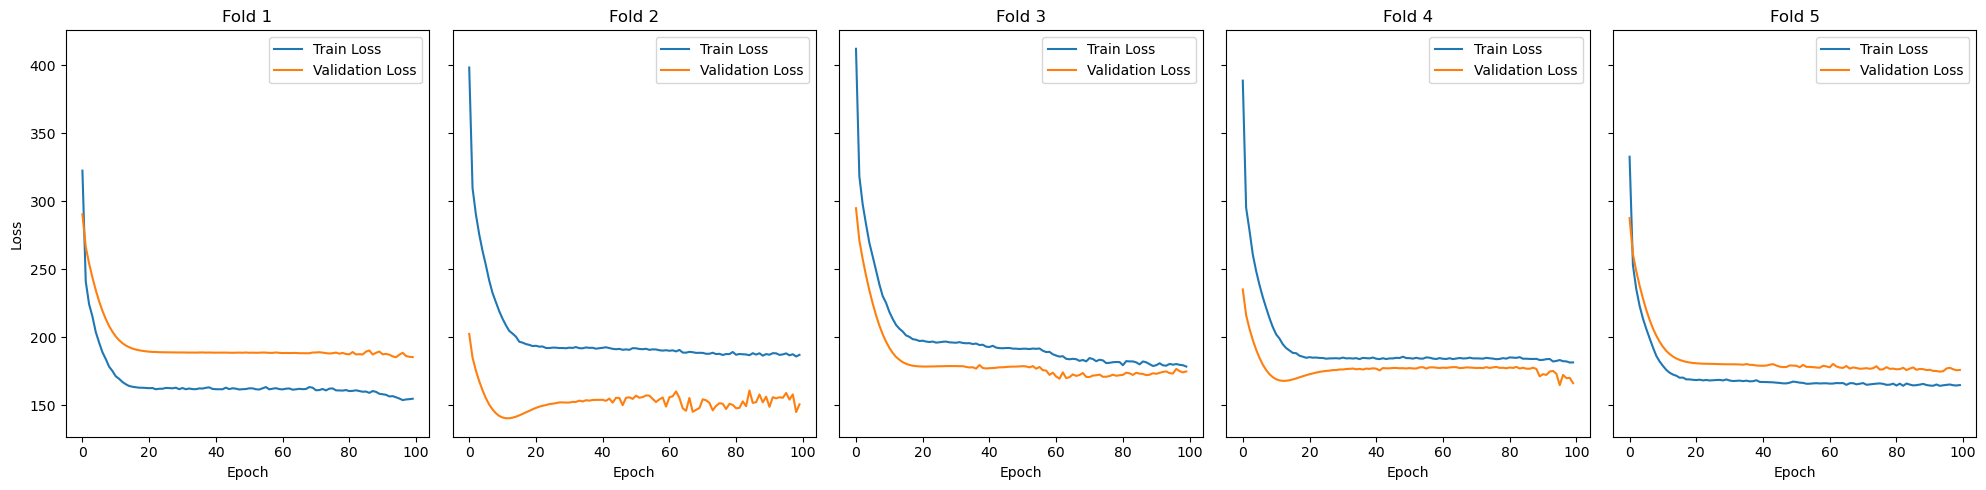

In [17]:
from models.transformer_pytorch import TimeSeriesTransformer
from utils.train_pipeline import run_optuna_study
from utils.utils import print_study_results, plot_best_model_results

n_trials = 3
num_epochs = 100
model_type = "Transformer"
model_name = "TransformerIndices"

suggestion_dict = {
    "learning_rate": {
        "type": "float",
        "args": [1e-5, 1e-3],
        "kwargs": {"log": True}
    },
    "d_model": {
        "type": "categorical",
        "args": [[64, 128, 256, 512]]
    },
    "n_heads": {
        "type": "categorical",
        "args": [[2, 4, 8, 16]]
    },
    "e_layers": {
        "type": "categorical",
        "args": [[1, 2, 3]]
    },
    "dim_feedforward": {
        "type": "categorical",
        "args": [[128, 256, 512]]
    },
    "dropout": {
        "type": "float",
        "args": [0.0, 0.5]
    },
    "batch_size": {
        "type": "categorical",
        "args": [[16, 32, 64, 128]]
    }
}

model_params_keys = ["d_model", "n_heads", "e_layers", "dim_feedforward", "dropout"]


model_results_dir = os.path.join(RESULTS_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs")
os.makedirs(model_results_dir, exist_ok=True)  

X = {"X_indices": X_indices}
run_optuna_study(pipeline.run_cross_val, TimeSeriesTransformer, model_type, suggestion_dict, model_params_keys, seed, X, y, NORMALIZE_FLAGS, model_results_dir, n_trials=n_trials, num_epochs=num_epochs)

study = joblib.load(os.path.join(model_results_dir, "study.pkl"))
print_study_results(study)
plot_best_model_results(
    study.trials_dataframe(),
    save_path=os.path.join(IMAGES_DIR, f"{model_name}_{n_trials}_trials_{num_epochs}_epochs_losses.png")
)